# Packages Loading

In [ ]:
import re
import nltk
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
nltk.download('stopwords')
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, DistilBertTokenizer, DistilBertForSequenceClassification, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, get_linear_schedule_with_warmup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the dataset
ds = pd.read_csv('/content/gdrive/MyDrive/Bengali_mbti_utf8.csv')

# Function to clean posts
def clean_post(post):
    post = re.sub(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*", "", post)  # Remove links
    post = re.sub(r'\|\|\|', '', post)  # Remove |||
    post = re.sub(r'\d+', '', post)  # Remove numbers
    return post

# Apply cleaning function to 'bengali_posts' column
ds['clean_posts'] = ds['bengali_posts'].astype(str).apply(clean_post)

# Function to remove stopwords and perform stemming
def preprocess_text(text):
    stop_words = set(stopwords.words('bengali'))
    stemmer = PorterStemmer()
    words = text.split()
    cleaned_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words and not re.match(r'[a-zA-Z]', word)]
    return ' '.join(cleaned_words)

# Apply preprocessing to 'clean_posts' column
ds['clean_posts'] = ds['clean_posts'].apply(preprocess_text)

# Drop NaN values
ds.dropna(subset=['clean_posts'], inplace=True)

# Display the cleaned dataset
print(ds.head())

   type                                      bengali_posts  \
0  INFJ  http://www.youtube.com/watch?v=qsXHcwe3krw|||h...   
1  ENTP  আমি এই পোস্টগুলিতে আমার অভাব খুঁজে পাচ্ছি। উদা...   
2  INTP  ভালো একটা _____ https://www.youtube.com/watch?...   
3  INTJ  প্রিয় INTP, আমি অন্য দিন আমাদের কথোপকথন উপভোগ...   
4  ENTJ  তোমাকে বরখাস্ত করা হয়েছে। যে সমীপবর্তী যৌক্তি...   

                                         clean_posts  
0  মুহূর্তগুলি স্পোর্টসসেন্টার সেরা দশটি নাটক জীব...  
1  পোস্টগুলিতে অভাব খুঁজে পাচ্ছি। উদাহরণস্বরূপ বা...  
2  ভালো একটা _____ বলি জানি; আশীর্বাদ অভিশাপ। হয়...  
3  প্রিয় কথোপকথন উপভোগ করেছি। মহাবিশ্বের প্রকৃতি...  
4  তোমাকে বরখাস্ত হয়েছে। সমীপবর্তী যৌক্তিকভাবে আ...  


In [ ]:
ds = ds.drop(columns='bengali_posts')

In [ ]:
ds=ds.dropna()

In [ ]:
ds

,type,clean_posts
0,INFJ,মুহূর্তগুলি স্পোর্টসসেন্টার সেরা দশটি নাটক জীব...
1,ENTP,পোস্টগুলিতে অভাব খুঁজে পাচ্ছি। উদাহরণস্বরূপ বা...
2,INTP,ভালো একটা _____ বলি জানি; আশীর্বাদ অভিশাপ। হয়...
3,INTJ,প্রিয় কথোপকথন উপভোগ করেছি। মহাবিশ্বের প্রকৃতি...
4,ENTJ,তোমাকে বরখাস্ত হয়েছে। সমীপবর্তী যৌক্তিকভাবে আ...
...,...,...
8670,ISFP,নির্দিষ্ট বিশ্বাস আছে। চাচ্ছি নিজেকে কোডের সীম...
8671,ENFP,"ব্যাপার না, পছন্দ নেই, নির্বাচন কেলেঙ্কারী ডেভ..."
8672,INTP,"বলব গ্রাউন্ডহগ ডে ভাল টাই আছে৷ আহ, দশক...|intp..."
8673,INFP,"পরীক্ষাটি লিঙ্গ, বয়স, প্রকারের কাছাকাছিও না।আ..."


In [ ]:
# Plot top stopwords
def plot_top_stopwords_barchart(text):
    stop = set(stopwords.words('bengali'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    from collections import defaultdict
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
    x, y = zip(*top)
    plt.bar(x, y)
    plt.show()

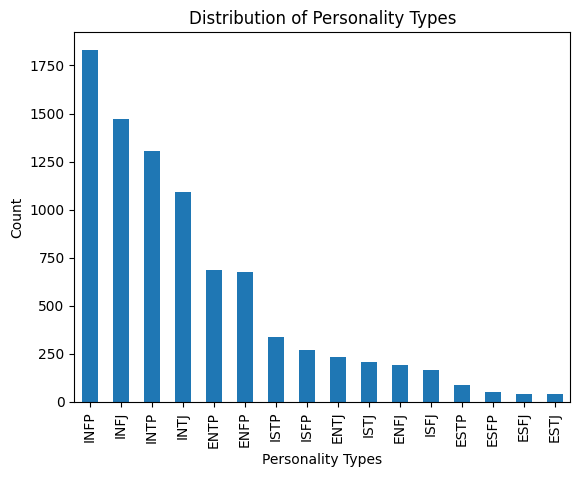

In [ ]:
# Plot personality type distribution
ds['type'].value_counts().plot(kind='bar')
plt.xlabel('Personality Types')
plt.ylabel('Count')
plt.title('Distribution of Personality Types')
plt.show()

In [ ]:
types = [str(t).lower() for t in ds["type"].dropna().unique()]
for post in ds["clean_posts"]:
    for word in post:
        if word.lower() in types:
            post.remove(word)

# Define Models and Tokenizer

In [ ]:
# Tokenizers
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
# Models
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=16,  # Number of unique labels
    output_attentions=False,
    output_hidden_states=False
)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=16,
    output_attentions=False,
    output_hidden_states=False
)

distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=16,
    output_attentions=False,
    output_hidden_states=False
)

models = {
    "mBERT": (bert_model, bert_tokenizer),
    "XLM-R": (xlmr_model, xlmr_tokenizer),
    "DistilBERT": (distilbert_model, distilbert_tokenizer)
}

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define Some Functions

In [ ]:
# Function to preprocess text for BERT
def preprocess_text_bert(text, tokenizer, max_len=128):
    tokenized_text = bert_tokenizer.tokenize(text)
    tokenized_text = ["[CLS]"] + tokenized_text + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    input_ids = input_ids[:max_len] + [tokenizer.pad_token_id] * (max_len - len(input_ids))
    attention_mask = [1] * len(input_ids)
    return torch.tensor(input_ids), torch.tensor(attention_mask)

# Function to preprocess text for DistilBERT
def preprocess_text_distilbert(text, tokenizer, max_len=128):
    inputs = distilbert_tokenizer(
       text,
       padding='max_length',
       truncation=True,
       max_length=max_len,
       return_tensors='pt'
    )
    return inputs.input_ids, inputs.attention_mask

def preprocess_text_xlmr(text, tokenizer, max_len=128):
    inputs = xlmr_tokenizer(
       text,
       padding='max_length',
       truncation=True,
       max_length=max_len,
       return_tensors='pt'
    )
    return inputs.input_ids, inputs.attention_mask


In [ ]:
# Function to train and evaluate a model
def train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, scheduler, device, epochs=3):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch
            model.zero_grad()
            outputs = model(inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Average Training Loss for {model.__class__.__name__}: {avg_train_loss}")

    model.eval()
    preds = []
    true_labels = []
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
        preds.append(logits.detach().cpu().numpy())
        true_labels.append(labels.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return preds, true_labels

In [ ]:
def plot_confusion_matrix(conf_matrix, label_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def calculate_metrics(true_labels, predicted_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    return conf_matrix, class_report, accuracy, f1, precision, recall


In [ ]:
# Function to plot ROC curve and calculate AUC
def plot_roc_curve(true_labels, predicted_probs, label_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(label_names)):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Define labels dictionary
labels_dict = {
    'INFJ': 0, 'ENTP': 1, 'INTP': 2, 'INTJ': 3, 'ENTJ': 4,
    'ENFJ': 5, 'INFP': 6, 'ENFP': 7, 'ISFP': 8, 'ISTP': 9,
    'ISFJ': 10, 'ISTJ': 11, 'ESTP': 12, 'ESFP': 13,
    'ESTJ': 14, 'ESFJ': 15
}

# Model Fine Tuning

In [ ]:
# Define batch size and other parameters
batch_size = 32
max_len = 128
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_ids_list = []
attention_mask_list = []

input_ids_list_xlmr = []
attention_mask_list_xlmr = []

input_ids_list_distilbert = []
attention_mask_list_distilbert = []

labels = [labels_dict[label] for label in ds['type'][:8000]]
labels = torch.tensor(labels)

for text in ds['clean_posts'][:8000]:
    # For mBERT
    input_ids, attention_mask = preprocess_text_bert(text, models['mBERT'][1], max_len)
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)

    # For XLM-R
    input_ids_xlmr, attention_mask_xlmr = preprocess_text_xlmr(text, models['XLM-R'][1], max_len)
    input_ids_list_xlmr.append(input_ids_xlmr)
    attention_mask_list_xlmr.append(attention_mask_xlmr)

    # For DistilBERT
    input_ids_distilbert, attention_mask_distilbert = preprocess_text_distilbert(text, models['DistilBERT'][1], max_len)
    input_ids_list_distilbert.append(input_ids_distilbert)
    attention_mask_list_distilbert.append(attention_mask_distilbert)


input_ids_tensor_bert = torch.stack(input_ids_list)
attention_mask_tensor_bert = torch.stack(attention_mask_list)

input_ids_tensor_xlmr = torch.stack(input_ids_list_xlmr)
attention_mask_tensor_xlmr = torch.stack(attention_mask_list_xlmr)

input_ids_tensor_distilbert = torch.stack(input_ids_list_distilbert)
attention_mask_tensor_distilbert = torch.stack(attention_mask_list_distilbert)


# Train Test Split

In [ ]:
# For BERT

train_inputs_bert, test_inputs_bert, train_masks_bert, test_masks_bert, train_labels_bert, test_labels_bert = train_test_split(
    input_ids_tensor_bert, attention_mask_tensor_bert, labels, test_size=0.3, random_state=42
)

train_data_bert = TensorDataset(train_inputs_bert, train_masks_bert, train_labels_bert)
train_sampler_bert = RandomSampler(train_data_bert)
train_dataloader_bert = DataLoader(train_data_bert, sampler=train_sampler_bert, batch_size=batch_size)

test_data_bert = TensorDataset(test_inputs_bert, test_masks_bert, test_labels_bert)
test_sampler_bert = SequentialSampler(test_data_bert)
test_dataloader_bert = DataLoader(test_data_bert, sampler=test_sampler_bert, batch_size=batch_size)



# For XLM-R
train_inputs_xlmr, test_inputs_xlmr, train_masks_xlmr, test_masks_xlmr, train_labels_xlmr, test_labels_xlmr = train_test_split(
    input_ids_tensor_xlmr, attention_mask_tensor_xlmr, labels, test_size=0.3, random_state=42
)

train_data_xlmr = TensorDataset(train_inputs_xlmr, train_masks_xlmr, train_labels_xlmr)
train_sampler_xlmr = RandomSampler(train_data_xlmr)
train_dataloader_xlmr = DataLoader(train_data_xlmr, sampler=train_sampler_xlmr, batch_size=batch_size)

test_data_xlmr = TensorDataset(test_inputs_xlmr, test_masks_xlmr, test_labels_xlmr)
test_sampler_xlmr = SequentialSampler(test_data_xlmr)
test_dataloader_xlmr = DataLoader(test_data_xlmr, sampler=test_sampler_xlmr, batch_size=batch_size)

# For DistilBERT
train_inputs_distilbert, test_inputs_distilbert, train_masks_distilbert, test_masks_distilbert, train_labels_distilbert, test_labels_distilbert = train_test_split(
    input_ids_tensor_distilbert, attention_mask_tensor_distilbert, labels, test_size=0.3, random_state=42
)

train_data_distilbert = TensorDataset(train_inputs_distilbert, train_masks_distilbert, train_labels_distilbert)
train_sampler_distilbert = RandomSampler(train_data_distilbert)
train_dataloader_distilbert = DataLoader(train_data_distilbert, sampler=train_sampler_distilbert, batch_size=batch_size)

test_data_distilbert = TensorDataset(test_inputs_distilbert, test_masks_distilbert, test_labels_distilbert)
test_sampler_distilbert = SequentialSampler(test_data_distilbert)
test_dataloader_distilbert = DataLoader(test_data_distilbert, sampler=test_sampler_distilbert, batch_size=batch_size)




# Define a dictionary to store train data loaders for each model
train_dataloaders_dict = {
    "mBERT": train_dataloader_bert,
    "XLM-R": train_dataloader_xlmr,
    "DistilBERT": train_dataloader_distilbert
}


# Define a dictionary to store train data loaders for each model
test_dataloaders_dict = {
    "mBERT": test_dataloader_bert,
    "XLM-R": test_dataloader_xlmr,
    "DistilBERT": test_dataloader_distilbert
}



In [ ]:
results = {}

# Training and evaluation loop for all models
for model_name, (model, tokenizer) in models.items():
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloaders_dict[model_name]) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    print(f"Training {model_name}...")

    # Move model to device
    model.to(device)

    if model_name == 'XLM-R' or model_name == 'DistilBERT' or model_name == 'mBERT':
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for batch in tqdm(train_dataloaders_dict[model_name], desc=f"Epoch {epoch + 1}"):
                batch = tuple(t.to(device) for t in batch)
                inputs, masks, labels = batch

                inputs = inputs.squeeze(1)  # Remove the extra dimension
                masks = masks.squeeze(1)  # Remove the extra dimension

                model.zero_grad()
                outputs = model(inputs, attention_mask=masks, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_dataloaders_dict[model_name])
            print(f"Average Training Loss for {model_name}: {avg_train_loss}")

    # Evaluation loop for BERT
    if model_name == 'mBERT':
        model.eval()
        preds_bert = []
        for batch in tqdm(test_dataloader_bert, desc="Evaluating BERT"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch
            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_bert.append(logits)
        preds_bert = np.concatenate(preds_bert, axis=0)
        results[model_name] = preds_bert

    # Evaluation loop for DistilBERT
    elif model_name == 'DistilBERT':
        model.eval()
        preds_distilbert = []
        for batch in tqdm(test_dataloader_distilbert, desc="Evaluating DistilBERT"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch

            # Ensure correct shape of inputs and masks
            inputs = inputs.squeeze(1)  # Remove the extra dimension
            masks = masks.squeeze(1)  # Remove the extra dimension

            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_distilbert.append(logits)
        preds_distilbert = np.concatenate(preds_distilbert, axis=0)
        results[model_name] = preds_distilbert

    # Evaluation loop for XLM-R
    elif model_name == 'XLM-R':
        model.eval()
        preds_xlmr = []
        for batch in tqdm(test_dataloader_xlmr, desc="Evaluating XLM-R"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch

            # Ensure correct shape of inputs and masks
            inputs = inputs.squeeze(1)  # Remove the extra dimension
            masks = masks.squeeze(1)  # Remove the extra dimension

            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_xlmr.append(logits)
        preds_xlmr = np.concatenate(preds_xlmr, axis=0)
        results[model_name] = preds_xlmr

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training mBERT...


Epoch 1: 100%|██████████| 175/175 [01:49<00:00,  1.60it/s]


Average Training Loss for mBERT: 2.3006874309267316


Epoch 2: 100%|██████████| 175/175 [01:54<00:00,  1.53it/s]


Average Training Loss for mBERT: 2.29209367615836


Epoch 3: 100%|██████████| 175/175 [01:56<00:00,  1.50it/s]


Average Training Loss for mBERT: 2.285341546194894


Evaluating BERT: 100%|██████████| 75/75 [00:15<00:00,  4.72it/s]


Training XLM-R...


Epoch 1: 100%|██████████| 175/175 [02:05<00:00,  1.40it/s]


Average Training Loss for XLM-R: 2.3016043513161795


Epoch 2: 100%|██████████| 175/175 [02:05<00:00,  1.40it/s]


Average Training Loss for XLM-R: 2.295472994531904


Epoch 3: 100%|██████████| 175/175 [02:05<00:00,  1.40it/s]


Average Training Loss for XLM-R: 2.2905110658918106


Evaluating XLM-R: 100%|██████████| 75/75 [00:15<00:00,  4.69it/s]


Training DistilBERT...


Epoch 1: 100%|██████████| 175/175 [01:00<00:00,  2.88it/s]


Average Training Loss for DistilBERT: 2.2967040606907436


Epoch 2: 100%|██████████| 175/175 [01:00<00:00,  2.88it/s]


Average Training Loss for DistilBERT: 2.2916853877476284


Epoch 3: 100%|██████████| 175/175 [01:00<00:00,  2.87it/s]


Average Training Loss for DistilBERT: 2.2855403218950543


Evaluating DistilBERT: 100%|██████████| 75/75 [00:08<00:00,  9.17it/s]


# ROC Curve

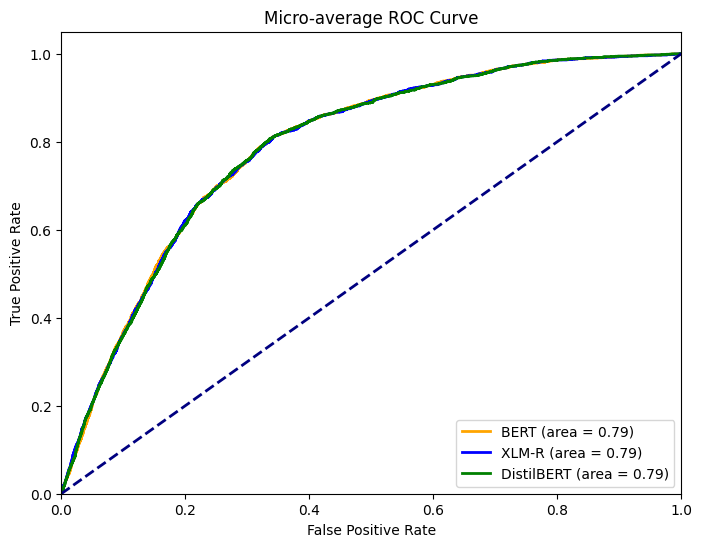

In [ ]:
from sklearn.metrics import roc_curve, auc

# Convert labels to one-hot encoded format for BERT
one_hot_labels_bert = np.zeros((len(test_labels_bert), len(labels_dict)))
for i, label in enumerate(test_labels_bert):
    one_hot_labels_bert[i, label] = 1

# Compute probabilities for each class for BERT
probabilities_bert = np.exp(preds_bert) / np.exp(preds_bert).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for BERT
fpr_bert = dict()
tpr_bert = dict()
roc_auc_bert = dict()
for i in range(len(labels_dict)):
    fpr_bert[i], tpr_bert[i], _ = roc_curve(one_hot_labels_bert[:, i], probabilities_bert[:, i])
    roc_auc_bert[i] = auc(fpr_bert[i], tpr_bert[i])

# Compute micro-average ROC curve and AUC score for BERT
fpr_bert["micro"], tpr_bert["micro"], _ = roc_curve(one_hot_labels_bert.ravel(), probabilities_bert.ravel())
roc_auc_bert["micro"] = auc(fpr_bert["micro"], tpr_bert["micro"])

# Convert labels to one-hot encoded format for XLM-R
one_hot_labels_xlmr = np.zeros((len(test_labels_xlmr), len(labels_dict)))
for i, label in enumerate(test_labels_xlmr):
    one_hot_labels_xlmr[i, label] = 1

# Compute probabilities for each class for XLM-R
probabilities_xlmr = np.exp(preds_xlmr) / np.exp(preds_xlmr).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for XLM-R
fpr_xlmr = dict()
tpr_xlmr = dict()
roc_auc_xlmr = dict()
for i in range(len(labels_dict)):
    fpr_xlmr[i], tpr_xlmr[i], _ = roc_curve(one_hot_labels_xlmr[:, i], probabilities_xlmr[:, i])
    roc_auc_xlmr[i] = auc(fpr_xlmr[i], tpr_xlmr[i])

# Compute micro-average ROC curve and AUC score for XLM-R
fpr_xlmr["micro"], tpr_xlmr["micro"], _ = roc_curve(one_hot_labels_xlmr.ravel(), probabilities_xlmr.ravel())
roc_auc_xlmr["micro"] = auc(fpr_xlmr["micro"], tpr_xlmr["micro"])

# Convert labels to one-hot encoded format for DistilBERT
one_hot_labels_distilbert = np.zeros((len(test_labels_distilbert), len(labels_dict)))
for i, label in enumerate(test_labels_distilbert):
    one_hot_labels_distilbert[i, label] = 1

# Compute probabilities for each class for DistilBERT
probabilities_distilbert = np.exp(preds_distilbert) / np.exp(preds_distilbert).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for DistilBERT
fpr_distilbert = dict()
tpr_distilbert = dict()
roc_auc_distilbert = dict()
for i in range(len(labels_dict)):
    fpr_distilbert[i], tpr_distilbert[i], _ = roc_curve(one_hot_labels_distilbert[:, i], probabilities_distilbert[:, i])
    roc_auc_distilbert[i] = auc(fpr_distilbert[i], tpr_distilbert[i])

# Compute micro-average ROC curve and AUC score for DistilBERT
fpr_distilbert["micro"], tpr_distilbert["micro"], _ = roc_curve(one_hot_labels_distilbert.ravel(), probabilities_distilbert.ravel())
roc_auc_distilbert["micro"] = auc(fpr_distilbert["micro"], tpr_distilbert["micro"])

# Plot micro-average ROC curve for all models
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert["micro"], tpr_bert["micro"], color='orange', lw=2, label=f'BERT (area = {roc_auc_bert["micro"]:.2f})')
plt.plot(fpr_xlmr["micro"], tpr_xlmr["micro"], color='blue', lw=2, label=f'XLM-R (area = {roc_auc_xlmr["micro"]:.2f})')
plt.plot(fpr_distilbert["micro"], tpr_distilbert["micro"], color='green', lw=2, label=f'DistilBERT (area = {roc_auc_distilbert["micro"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Classification Report

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Convert predicted labels to the original label format
pred_labels_bert = np.argmax(probabilities_bert, axis=1)
pred_labels_xlmr = np.argmax(probabilities_xlmr, axis=1)
pred_labels_distilbert = np.argmax(probabilities_distilbert, axis=1)

# Compute classification report, accuracy, precision, recall, and F1 score for BERT
class_report_bert = classification_report(test_labels_bert, pred_labels_bert)
accuracy_bert = accuracy_score(test_labels_bert, pred_labels_bert)
precision_bert = precision_score(test_labels_bert, pred_labels_bert, average='weighted')
recall_bert = recall_score(test_labels_bert, pred_labels_bert, average='weighted')
f1_bert = f1_score(test_labels_bert, pred_labels_bert, average='weighted')

# Compute classification report, accuracy, precision, recall, and F1 score for XLM-R
class_report_xlmr = classification_report(test_labels_xlmr, pred_labels_xlmr)
accuracy_xlmr = accuracy_score(test_labels_xlmr, pred_labels_xlmr)
precision_xlmr = precision_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')
recall_xlmr = recall_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')
f1_xlmr = f1_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')

# Compute classification report, accuracy, precision, recall, and F1 score for DistilBERT
class_report_distilbert = classification_report(test_labels_distilbert, pred_labels_distilbert)
accuracy_distilbert = accuracy_score(test_labels_distilbert, pred_labels_distilbert)
precision_distilbert = precision_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')
recall_distilbert = recall_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')
f1_distilbert = f1_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')

# Print classification reports
print("Classification Report for BERT:")
print(class_report_bert)
print(f"Accuracy for BERT: {accuracy_bert}")
print(f"Precision for BERT: {precision_bert}")
print(f"Recall for BERT: {recall_bert}")
print(f"F1 Score for BERT: {f1_bert}")
print()

print("Classification Report for XLM-R:")
print(class_report_xlmr)
print(f"Accuracy for XLM-R: {accuracy_xlmr}")
print(f"Precision for XLM-R: {precision_xlmr}")
print(f"Recall for XLM-R: {recall_xlmr}")
print(f"F1 Score for XLM-R: {f1_xlmr}")
print()

print("Classification Report for DistilBERT:")
print(class_report_distilbert)
print(f"Accuracy for DistilBERT: {accuracy_distilbert}")
print(f"Precision for DistilBERT: {precision_distilbert}")
print(f"Recall for DistilBERT: {recall_distilbert}")
print(f"F1 Score for DistilBERT: {f1_distilbert}")


Classification Report for BERT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       403
           1       0.00      0.00      0.00       186
           2       0.00      0.00      0.00       374
           3       0.00      0.00      0.00       299
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00        53
           6       0.21      1.00      0.35       511
           7       0.00      0.00      0.00       180
           8       0.00      0.00      0.00        64
           9       0.00      0.00      0.00        95
          10       0.00      0.00      0.00        51
          11       0.00      0.00      0.00        50
          12       0.00      0.00      0.00        31
          13       0.00      0.00      0.00        14
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00         9

    accuracy                           0.21     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix for BERT
conf_matrix_bert = confusion_matrix(test_labels_bert, pred_labels_bert)

# Compute confusion matrix for XLM-R
conf_matrix_xlmr = confusion_matrix(test_labels_xlmr, pred_labels_xlmr)

# Compute confusion matrix for DistilBERT
conf_matrix_distilbert = confusion_matrix(test_labels_distilbert, pred_labels_distilbert)

# Define label names based on labels dictionary
label_names = sorted(labels_dict, key=labels_dict.get)


<Figure size 800x600 with 0 Axes>

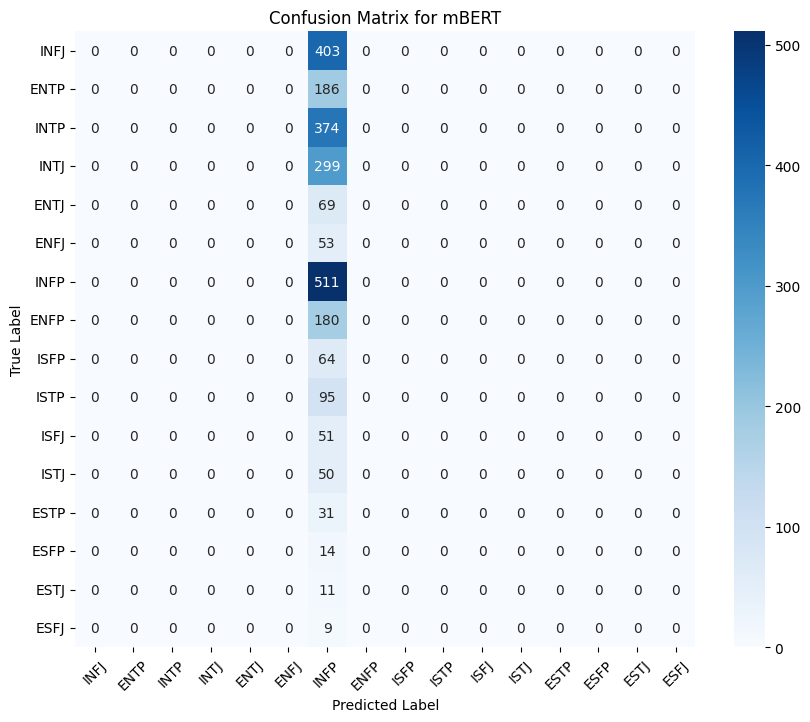

<Figure size 800x600 with 0 Axes>

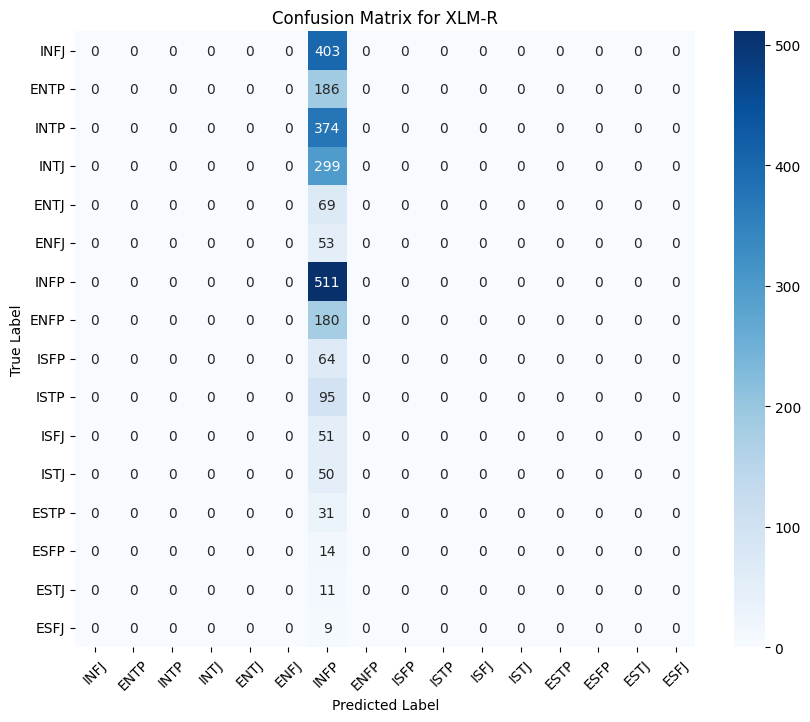

<Figure size 800x600 with 0 Axes>

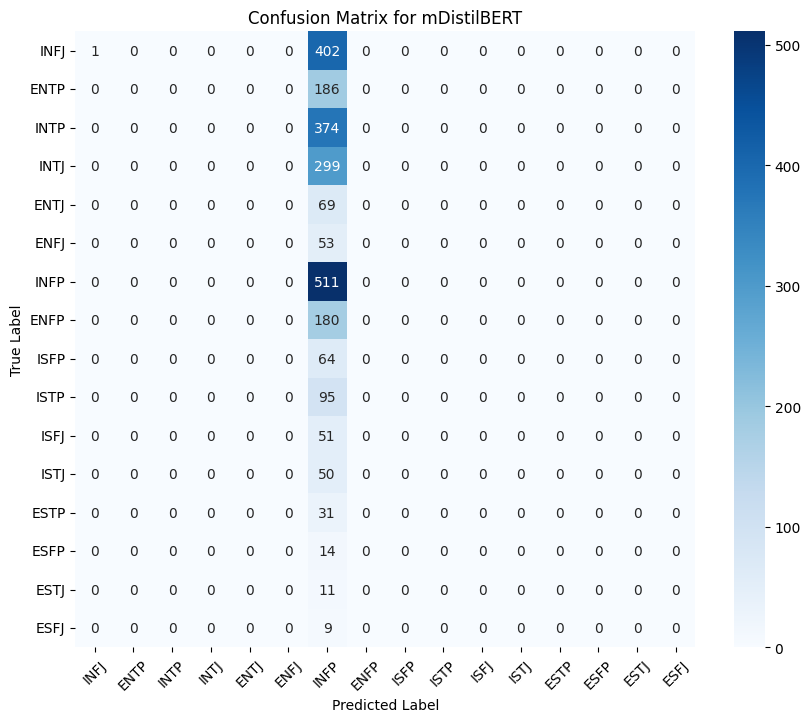

In [ ]:
import seaborn as sns

def plot_confusion_matrix(conf_matrix, label_names, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title(title)  # Set the title here
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Plot confusion matrix for BERT
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_bert, label_names, 'Confusion Matrix for mBERT')

# Plot confusion matrix for XLM-R
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_xlmr, label_names, 'Confusion Matrix for XLM-R')

# Plot confusion matrix for DistilBERT
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_distilbert, label_names, 'Confusion Matrix for mDistilBERT')

# Save the Best Performing Model

In [ ]:
import pickle

# Define the path where you want to save the model
model_save_path = '/content/gdrive/MyDrive/models/final_distilbert_bn.pkl'

# Save the model using pickle
with open(model_save_path, 'wb') as f:
    pickle.dump(distilbert_model, f)


# Cyber Bullying


In [ ]:
cb = pd.read_csv('/content/gdrive/MyDrive/Bengali_cyber_utf8.csv')
cb

,tweet_text,cyberbullying_type,Unnamed: 2
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"অন্য কথায় #কাতান্ডেন্দ্রে, আপনার খাবার ছিল বি..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,#aussietv এত সাদা কেন? #MKR #theblock #ImACEel...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,@XochitlSuckkks একটি উত্কৃষ্ট বেশ্যা? নাকি আরও...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"@জেসন_জিও মেহ। :P মাথা আপ জন্য ধন্যবাদ, কিন্তু..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,@RudhoeEnglish এটি একটি ISIS অ্যাকাউন্ট যা একট...
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,"ব্ল্যাক পিপিএল কিছু করবে বলে আশা করা হয় না, য..."
47688,Turner did not withhold his disappointment. Tu...,ethnicity,টার্নার তার হতাশাকে দমিয়ে রাখেননি। টার্নার আদ...
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,খোদার কসম. এই বোবা নিগার কুত্তা. আমি শীঘ্রই আম...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,ইয়ে ফাক ইউ আরটি


In [ ]:
# Drop a column
cb.drop(columns=['tweet_text'], inplace=True)
cb.rename(columns={'Unnamed: 2': 'tweet_text'}, inplace=True)
cb

,cyberbullying_type,tweet_text
0,not_cyberbullying,"অন্য কথায় #কাতান্ডেন্দ্রে, আপনার খাবার ছিল বি..."
1,not_cyberbullying,#aussietv এত সাদা কেন? #MKR #theblock #ImACEel...
2,not_cyberbullying,@XochitlSuckkks একটি উত্কৃষ্ট বেশ্যা? নাকি আরও...
3,not_cyberbullying,"@জেসন_জিও মেহ। :P মাথা আপ জন্য ধন্যবাদ, কিন্তু..."
4,not_cyberbullying,@RudhoeEnglish এটি একটি ISIS অ্যাকাউন্ট যা একট...
...,...,...
47687,ethnicity,"ব্ল্যাক পিপিএল কিছু করবে বলে আশা করা হয় না, য..."
47688,ethnicity,টার্নার তার হতাশাকে দমিয়ে রাখেননি। টার্নার আদ...
47689,ethnicity,খোদার কসম. এই বোবা নিগার কুত্তা. আমি শীঘ্রই আম...
47690,ethnicity,ইয়ে ফাক ইউ আরটি


<Axes: xlabel='cyberbullying_type'>

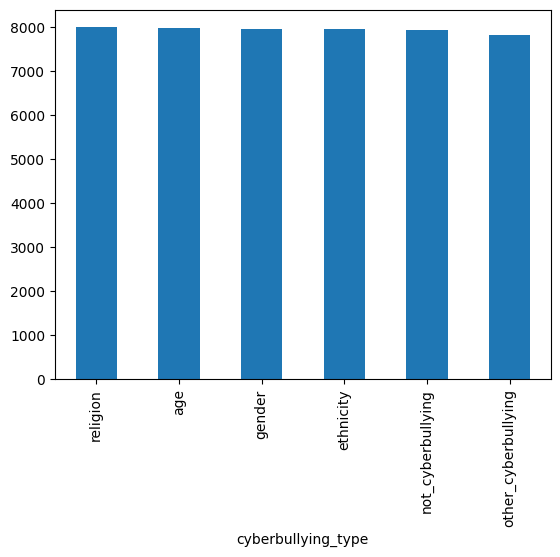

In [ ]:
# Plot the count of each cyberbullying type
cb["cyberbullying_type"].value_counts().plot(kind="bar")

In [ ]:
# Truncate cyberbullying types to 30 characters
cb['cyberbullying_type'] = cb['cyberbullying_type'].str[:30]

In [ ]:
# Create a dictionary to store DataFrames categorized by the first 10 characters
dfs = {}

In [ ]:
# Iterate over unique categories and store filtered DataFrames
for cyberbullying_type in cb['cyberbullying_type'].unique():
    category_cb = cb[cb['cyberbullying_type'] == cyberbullying_type].drop(columns=['cyberbullying_type'])
    dfs[cyberbullying_type] = category_cb

In [ ]:
# Print the segregated DataFrames
for key, value in dfs.items():
    print(f"\nDataFrame for category '{key}':")
    # print(value)


DataFrame for category 'not_cyberbullying':

DataFrame for category 'gender':

DataFrame for category 'religion':

DataFrame for category 'other_cyberbullying':

DataFrame for category 'age':

DataFrame for category 'ethnicity':


In [ ]:
# Store the segregated DataFrames in a dictionary
segregated_cbs = {
    'not_cyberbul': cb[cb['cyberbullying_type'] == 'not_cyberbul'],
    'gender': cb[cb['cyberbullying_type'] == 'gender'],
    'religion': cb[cb['cyberbullying_type'] == 'religion'],
    'other_cyberb': cb[cb['cyberbullying_type'] == 'not_cyberbul'],
    'age': cb[cb['cyberbullying_type'] == 'age'],
    'ethnicity': cb[cb['cyberbullying_type'] == 'ethnicity']
}

In [ ]:
# Access the segregated DataFrames using their respective category names
not_cyberbul_cb = segregated_cbs['not_cyberbul']
gender_cb = segregated_cbs['gender']
religion_cb = segregated_cbs['religion']
other_cyberb_cb = segregated_cbs['other_cyberb']
age_cb = segregated_cbs['age']
ethnicity_cb = segregated_cbs['ethnicity']

In [ ]:
# Example: Accessing the 'not_cyberbul' DataFrame
print("Not Cyberbullying DataFrame:")
print(not_cyberbul_cb)

Not Cyberbullying DataFrame:
Empty DataFrame
Columns: [cyberbullying_type, tweet_text]
Index: []


In [ ]:
gender_cb

,cyberbullying_type,tweet_text
7945,gender,ধর্ষণ আসল
7946,gender,আপনি কোন সেলিব্রিটিকে ওবামার জন্য এরকম কিছু বল...
7947,gender,"@ManhattaKnight আমি বলতে চাচ্ছি যে সে সমকামী, ..."
7948,gender,RT @Raul_Novoa16: @Alicia Bernardez @Alex_Aim ...
7949,gender,ধর্ষণই ধর্ষণ। এবং সত্য যে আমি একটি লোক ধর্ষিত ...
...,...,...
15913,gender,যেকোন মহিলা যারা আমাকে সত্যিই চেনেন তারা জানেন...
15914,gender,"RT @_chrisdowns_: #QuestionsForMen এটা ভালো, এ..."
15915,gender,নিজের মুখের হাসিটা মুছে দিতেই চুষেছেন তাই না? ...
15916,gender,না। তিনি বলেছিলেন যে মহিলারা সমকামী হতে পছন্দ ...


In [ ]:
# Initialize Porter Stemmer
ps = PorterStemmer()

# Load the pre-trained BERT model
with open('/content/gdrive/MyDrive/models/final_distilbert_bn.pkl', 'rb') as f:
    bert_model = pickle.load(f)

In [ ]:


# Define function for tweet preprocessing
def preprocess_tweets(tweets):
    corpus = []
    for tweet in tweets:
        # Remove non-alphabetic characters and convert to lowercase
        tweet_text = re.sub("[^a-zA-Z]", " ", tweet)
        tweet_text = tweet_text.lower()

        # Tokenize the tweet
        tweet_text = tweet_text.split()

        # Remove stopwords and apply stemming
        tweet_text = [ps.stem(word) for word in tweet_text if word not in stopwords.words("bengali")]

        # Join the processed words back into a single string
        tweet_text = " ".join(tweet_text)

        # Append the processed tweet to the corpus
        corpus.append(tweet_text)
    return corpus

def process_and_predict(df, category_name, reverse_class_labels):
    # Preprocess tweets
    df["tweet_text"] = df["tweet_text"].fillna("")
    corpus = preprocess_tweets(df["tweet_text"])

    # Tokenize the cleaned texts
    tokenized_texts = [distilbert_tokenizer.encode(text, add_special_tokens=True) for text in corpus]

    # Pad sequences to ensure uniform length
    max_len = max(len(tokens) for tokens in tokenized_texts)
    padded_texts = [tokens + [0] * (max_len - len(tokens)) for tokens in tokenized_texts]

    # Predict labels
    predicted_labels = predict_labels(padded_texts, reverse_class_labels)

    # Create a new DataFrame to store the original data along with the predicted labels
    predicted_df = df.copy()
    predicted_df['predicted_labels'] = predicted_labels[:len(df)]

    # Print the unique predicted labels
    unique_labels = predicted_df['predicted_labels'].unique()
    print(f"Unique labels for '{category_name}': {unique_labels}")

    # Count the occurrences of each label
    label_counts = Counter(predicted_labels)
    for label, count in label_counts.items():
        print(f"{label}: {count} samples")

    return predicted_df

# Define function for DistilBERT prediction
def predict_labels(tokenized_texts, reverse_class_labels):
    predicted_labels = []
    for i in tqdm(range(0, len(tokenized_texts), batch_size), desc="Predicting"):
        input_batch = torch.tensor(tokenized_texts[i:i+batch_size]).to(device)
        with torch.no_grad():
            outputs = distilbert_model(input_batch)
            logits = outputs.logits

        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class index for each sample in the batch
        batch_predicted_class_indices = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Convert the class indices back to their original labels
        batch_predicted_labels = [reverse_class_labels.get(idx, "Unknown") for idx in batch_predicted_class_indices]

        predicted_labels.extend(batch_predicted_labels)
    return predicted_labels


# Print the predicted result

In [ ]:
# Define categories and respective DataFrames
categories = {
    'age': age_cb,
    'religion': religion_cb,
    'gender': gender_cb,
    'ethnicity': ethnicity_cb,
    # Add more categories as needed
}

class_labels = {
        'INFJ': 0, 'ENTP': 1, 'INTP': 2, 'INTJ': 3, 'ENTJ': 4,
        'ENFJ': 5, 'INFP': 6, 'ENFP': 7, 'ISFP': 8, 'ISTP': 9,
        'ISFJ': 10, 'ISTJ': 11, 'ESTP': 12, 'ESFP': 13,
        'ESTJ': 14, 'ESFJ': 15
    }

# Reverse the class_labels dictionary to map indices to labels
reverse_class_labels = {v: k for k, v in class_labels.items()}

# Create dictionaries to store predicted DataFrames for each category
predicted_dfs = {}

# Iterate over categories, process and predict labels
for category_name, df in categories.items():
    print(f"\nProcessing category '{category_name}':")
    predicted_df = process_and_predict(df, category_name, reverse_class_labels)
    # Store the predicted DataFrame for the category
    predicted_dfs[category_name] = predicted_df
    print(f"Predicted DataFrame for '{category_name}':\n{predicted_df.head()}")

# Print keys in the predicted_dfs dictionary
print("\nKeys in predicted_dfs dictionary:", predicted_dfs.keys())


Processing category 'age':


<ipython-input-56-6edc421e5080>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")
Predicting: 100%|██████████| 250/250 [00:30<00:00,  8.23it/s]
<ipython-input-56-6edc421e5080>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'age': ['INFP']
INFP: 7992 samples
Predicted DataFrame for 'age':
      cyberbullying_type                                         tweet_text  \
31739                age  এখানে বাড়িতে। প্রতিবেশীরা আমার পরিবার এবং আমি...   
31740                age  স্কুলে উত্যক্ত করা: উচ্চ-প্রাপ্ত ছেলেরা পুরুষত...   
31741                age  আমার ক্লাসে 6ষ্ঠ শ্রেণীতে একটি মেয়ে ছিল যেটি ...   
31742                age  সে সম্ভবত শহরতলির একটি সাদা সমকামী বাচ্চা। আমর...   
31743                age  আপনি টি অবলম্বন ধাক্কা হয়. বুলিদের সাথে আচরণ ...   

      predicted_labels  
31739             INFP  
31740             INFP  
31741             INFP  
31742             INFP  
31743             INFP  

Processing category 'religion':


Predicting: 100%|██████████| 250/250 [00:24<00:00, 10.26it/s]
<ipython-input-56-6edc421e5080>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'religion': ['INFP']
INFP: 7998 samples
Predicted DataFrame for 'religion':
      cyberbullying_type                                         tweet_text  \
15918           religion  সুদীপ, সে কি তাকে আমন্ত্রণ জানিয়েছে? কোন অধিক...   
15919           religion  @বিবেচক মুমিন ইসলাম কখনোই নিপীড়নের প্রতিরোধ ক...   
15920           religion  ছেলে, গীর্জা বন্ধ রাখতে চায় সাংবাদিকদের সম্পর...   
15921           religion  @শশীথারুর @INCIndia কাশ্মীরে হিন্দুরা মুসলিম স...   
15922           religion  সাদা আধিপত্যবাদী? কতজন জানেন? সব জাতিতে কিছু ই...   

      predicted_labels  
15918             INFP  
15919             INFP  
15920             INFP  
15921             INFP  
15922             INFP  

Processing category 'gender':


Predicting: 100%|██████████| 250/250 [00:19<00:00, 12.60it/s]
<ipython-input-56-6edc421e5080>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'gender': ['INFP']
INFP: 7973 samples
Predicted DataFrame for 'gender':
     cyberbullying_type                                         tweet_text  \
7945             gender                                          ধর্ষণ আসল   
7946             gender  আপনি কোন সেলিব্রিটিকে ওবামার জন্য এরকম কিছু বল...   
7947             gender  @ManhattaKnight আমি বলতে চাচ্ছি যে সে সমকামী, ...   
7948             gender  RT @Raul_Novoa16: @Alicia Bernardez @Alex_Aim ...   
7949             gender  ধর্ষণই ধর্ষণ। এবং সত্য যে আমি একটি লোক ধর্ষিত ...   

     predicted_labels  
7945             INFP  
7946             INFP  
7947             INFP  
7948             INFP  
7949             INFP  

Processing category 'ethnicity':


Predicting: 100%|██████████| 249/249 [00:23<00:00, 10.74it/s]

Unique labels for 'ethnicity': ['INFP']
INFP: 7961 samples
Predicted DataFrame for 'ethnicity':
      cyberbullying_type                                         tweet_text  \
39731          ethnicity  আরে বোবা ফাক সেলিব্রিটিরা ফেসবুকে প্রচারের জন্...   
39732          ethnicity  ফাক ইউ বিচ RT @tayyoung_: ফাক ওবামা, বোবা গাধা...   
39733          ethnicity  @জোবিডেন না জো, আপনি বর্ণবাদী। আপনার অতীতে আপন...   
39734          ethnicity  যখন আপনার ট্রাক বোবা দেখায় তখন এটিকে আরও খারা...   
39735          ethnicity            ক্যাফেতে সেই নিগার খাবারটি আজ জঘন্য ছিল   

      predicted_labels  
39731             INFP  
39732             INFP  
39733             INFP  
39734             INFP  
39735             INFP  

Keys in predicted_dfs dictionary: dict_keys(['age', 'religion', 'gender', 'ethnicity'])


In [ ]:
# Access the predicted DataFrame for a specific category
predicted_df_age = predicted_dfs.get('age')
predicted_df_religion = predicted_dfs.get('religion')

In [ ]:
predicted_df_age

,cyberbullying_type,tweet_text,predicted_labels
31739,age,এখানে বাড়িতে। প্রতিবেশীরা আমার পরিবার এবং আমি...,INFP
31740,age,স্কুলে উত্যক্ত করা: উচ্চ-প্রাপ্ত ছেলেরা পুরুষত...,INFP
31741,age,আমার ক্লাসে 6ষ্ঠ শ্রেণীতে একটি মেয়ে ছিল যেটি ...,INFP
31742,age,সে সম্ভবত শহরতলির একটি সাদা সমকামী বাচ্চা। আমর...,INFP
31743,age,আপনি টি অবলম্বন ধাক্কা হয়. বুলিদের সাথে আচরণ ...,INFP
...,...,...,...
39726,age,এই মেয়েটি সত্যিই বলার চেষ্টা করেছিল যে আমি তা...,INFP
39727,age,স্কুলে একজন ধর্ষক যে ৩য় শ্রেণী থেকে আমার সাথে...,INFP
39728,age,আমার মনে আছে আমি 6 তম গ্রেডে 'বো ডাউন' নামে এক...,INFP
39729,age,আমি প্রম কুইন ছিলাম না। আমি ছিলাম নির্যাতিত মে...,INFP
